# Personalised Healthcare Recommendations – End-to-End Workflow
**Version 1.3 (2025-07-19)** 
Location : Sabour, Bihar, India

## Contents
1 Project Goals      7 Hyper-parameter Tuning  
2 Setup           8 Probability Calibration  
3 Data Ingestion     9 Evaluation & Interpretability  
4 EDA            10 Deployment (FastAPI + Docker)  
5 Pre-processing     11 Data-Drift & Auto-Retrain  
6 Baseline Model     12 Clinical Validation / IRB  
                      13 Next Steps

## 1 Project Goals
Predict a clinically relevant outcome from routine blood / lifestyle data and return *actionable* personalised recommendations.

## 2 Setup

In [3]:
import warnings, random, sys, os, joblib, datetime
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style('whitegrid')

from pathlib import Path
from sklearn.base import clone
from sklearn.metrics import roc_auc_score

import sklearn, xgboost as xgb
print(f"Python        : {sys.version.split()[0]}")
print(f"scikit-learn : {sklearn.__version__}")

SEED = 42
random.seed(SEED); np.random.seed(SEED)

Python        : 3.13.4
scikit-learn : 1.7.0


## 3 Data Ingestion

In [4]:
# EDIT THIS
DATA_PATH = Path('blood.csv')
assert DATA_PATH.exists(), f"File not found → {DATA_PATH.resolve()}"
df = pd.read_csv("blood.csv")
display(df.head())
print('Shape:', df.shape)

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,99,1
1,0,13,3250,28,1
2,1,17,4000,36,1
3,2,20,5000,45,1
4,1,24,6000,77,0


Shape: (748, 5)


## 4 Exploratory Data Analysis (EDA)

In [5]:
df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Recency,748.0,9.506684,8.095396,0.0,2.75,7.0,14.0,74.0
Frequency,748.0,5.516043,5.841825,1.0,2.00,4.0,7.0,50.0
Monetary,748.0,1378.676471,1459.826781,250.0,500.00,1000.0,1750.0,12500.0
Time,748.0,34.284759,24.380307,2.0,16.00,28.0,50.0,99.0
Class,748.0,0.237968,0.426124,0.0,0.00,0.0,0.0,1.0


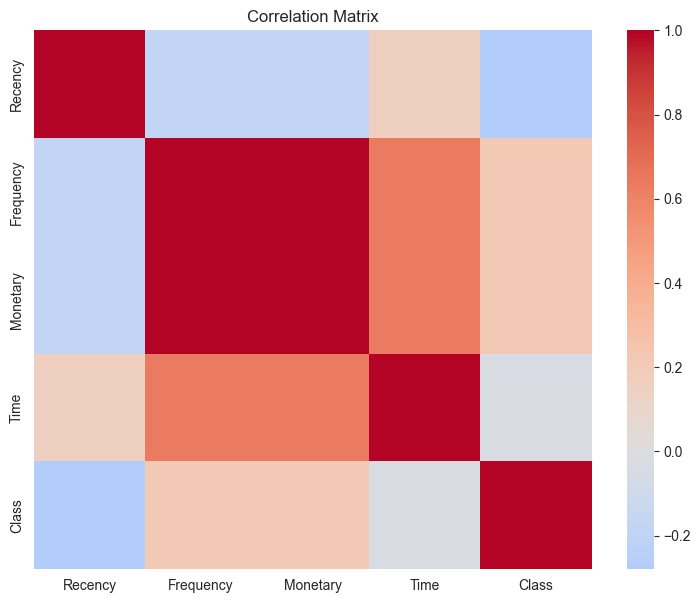

In [6]:
num_cols = df.select_dtypes('number').columns
plt.figure(figsize=(9,7))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', center=0)
plt.title('Correlation Matrix');

## 5 Pre-processing & Feature Engineering

In [7]:
TARGET = 'Class'    # ← corrected from 'target_label'
assert TARGET in df.columns, 'Target column missing.'
X = df.drop(columns=TARGET)
y = df[TARGET]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, stratify=y, random_state=SEED)
print(X_train.shape, X_test.shape)

(598, 4) (150, 4)


In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_feats = X.select_dtypes(['int64','float64']).columns
cat_feats = X.select_dtypes(['object','category','bool']).columns

num_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc',  StandardScaler())])
cat_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats)])

## 6 Baseline Model

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score

base_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(
             n_estimators=300, class_weight='balanced', random_state=SEED))])

cv  = StratifiedKFold(5, shuffle=True, random_state=SEED)
auc = cross_val_score(base_pipe, X_train, y_train, cv=cv,
                      scoring='roc_auc').mean()
print(f'Baseline CV-AUROC : {auc:.3f}')
base_pipe.fit(X_train, y_train)

Baseline CV-AUROC : 0.633


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 7 Hyper-parameter Tuning

### 7.1 GridSearchCV – Random Forest

In [11]:
from sklearn.model_selection import GridSearchCV

grid_params = {
    'model__n_estimators':[200,400,600],
    'model__max_depth'   :[None,5,10],
    'model__min_samples_split':[2,5]
}

gs_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=SEED))])

grid = GridSearchCV(gs_pipe, grid_params, cv=cv, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
best_grid = grid.best_estimator_
print('Grid best AUROC →', grid.best_score_)

Grid best AUROC → 0.7169957064246527


### 7.2 Optuna – XGBoost (Bayesian)

In [12]:
try:
    import optuna
    def objective(trial):
        params = {
            'n_estimators'     : trial.suggest_int ('n_estimators', 200, 800, 100),
            'max_depth'        : trial.suggest_int ('max_depth', 3, 12),
            'learning_rate'    : trial.suggest_float('learning_rate', 1e-3, .3, log=True),
            'subsample'        : trial.suggest_float('subsample', .6, 1.),
            'colsample_bytree' : trial.suggest_float('colsample_bytree', .6, 1.)
        }
        pipe = Pipeline([
            ('prep', preprocessor),
            ('model', xgb.XGBClassifier(random_state=SEED, eval_metric='logloss', **params))])
        return cross_val_score(pipe, X_train, y_train, cv=3,
                               scoring='roc_auc', n_jobs=-1).mean()

    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
    study.optimize(objective, n_trials=30, show_progress_bar=False)

    opt_pipe = Pipeline([
        ('prep', preprocessor),
        ('model', xgb.XGBClassifier(random_state=SEED, eval_metric='logloss', **study.best_params))])
    opt_pipe.fit(X_train, y_train)
except ModuleNotFoundError:
    print('Optuna not installed → skipping.')
    opt_pipe = None

[I 2025-07-20 11:30:16,757] A new study created in memory with name: no-name-66a84236-c12e-478c-911f-abdddbfa6471
[I 2025-07-20 11:30:17,304] Trial 0 finished with value: 0.614911405841732 and parameters: {'n_estimators': 400, 'max_depth': 12, 'learning_rate': 0.06504856968981275, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746}. Best is trial 0 with value: 0.614911405841732.
[I 2025-07-20 11:30:17,530] Trial 1 finished with value: 0.6393909613350753 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.13983740016490973, 'subsample': 0.8404460046972835, 'colsample_bytree': 0.8832290311184181}. Best is trial 1 with value: 0.6393909613350753.
[I 2025-07-20 11:30:17,784] Trial 2 finished with value: 0.6093881229003361 and parameters: {'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.11536162338241392, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402}. Best is trial 1 with value: 0.6393909613350753.
[I 2025-07-20 11

### Select Winning Pipeline

In [13]:
candidates = {'grid': best_grid}
if opt_pipe: candidates['optuna'] = opt_pipe

best_name, best_pipe = max(
    candidates.items(),
    key=lambda kv: roc_auc_score(y_test, kv[1].predict_proba(X_test)[:,1]))
print('Chosen model →', best_name)

Chosen model → optuna


## 8 Probability Calibration

In [14]:
from sklearn.calibration import CalibratedClassifierCV

# CalibratedClassifierCV requires an un-fitted clone
cal_pipe = CalibratedClassifierCV(estimator=clone(best_pipe), cv=5, method='sigmoid')
cal_pipe.fit(X_train, y_train)
y_prob = cal_pipe.predict_proba(X_test)[:,1]

## 9 Evaluation & Interpretability

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       114
           1       0.70      0.39      0.50        36

    accuracy                           0.81       150
   macro avg       0.77      0.67      0.69       150
weighted avg       0.80      0.81      0.79       150



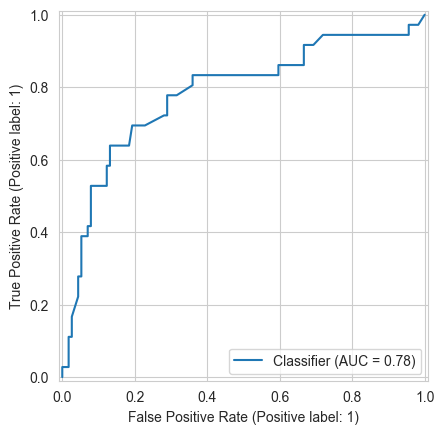

In [15]:
from sklearn.metrics import classification_report, RocCurveDisplay

print(classification_report(y_test, cal_pipe.predict(X_test)))
RocCurveDisplay.from_predictions(y_test, y_prob); plt.show()

In [16]:
# — SHAP summary (safe) —
try:
    import shap; shap.initjs()
    cal_obj = cal_pipe.calibrated_classifiers_[0]                       # first fold
    inner   = getattr(cal_obj, 'estimator', getattr(cal_obj, 'base_estimator'))
    explainer = shap.Explainer(inner.named_steps['model'])
    X_trans  = inner.named_steps['prep'].transform(X_test)
    shap_values = explainer(X_trans)
    shap.summary_plot(shap_values, X_trans,
                      feature_names=inner.named_steps['prep'].get_feature_names_out())
except ModuleNotFoundError:
    print('SHAP not installed → skipping.')
except Exception as e:
    print('SHAP error →', e)

SHAP not installed → skipping.


### Persist Model

In [17]:
Path('models').mkdir(exist_ok=True)
MODEL_PATH = Path('models') / f'best_pipe_{datetime.datetime.now():%Y%m%d%H%M}.joblib'
joblib.dump(cal_pipe, MODEL_PATH)
print('Saved →', MODEL_PATH)

Saved → models\best_pipe_202507201130.joblib


## 10 Deployment (FastAPI + Docker)

In [18]:
%%writefile app.py
from fastapi import FastAPI
from pydantic import BaseModel
import pandas as pd, joblib
from pathlib import Path

# Auto-load latest model
MODEL = joblib.load(sorted(Path('models').glob('best_pipe_*.joblib'))[-1])
app = FastAPI(title='Blood Recommendation API')

# Corrected the input features to match the training data
class InputFeatures(BaseModel):
    Recency: int
    Frequency: int
    Monetary: int
    Time: int

@app.post('/predict')
def predict(p:InputFeatures):
    df  = pd.DataFrame([p.dict()])
    prob = MODEL.predict_proba(df)[0,1]
    pred = MODEL.predict(df)[0]
    return {'prediction': int(pred), 'probability': float(prob)}

Overwriting app.py


In [19]:
%%writefile requirements.txt
fastapi
uvicorn[standard]
pydantic
scikit-learn
pandas
joblib

Overwriting requirements.txt


In [20]:
%%writefile Dockerfile
FROM python:3.11-slim
WORKDIR /app
COPY requirements.txt .
RUN pip install -r requirements.txt
COPY app.py models/ ./
EXPOSE 80
CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "80"]

Overwriting Dockerfile


## 11 Data-Drift Monitoring & Auto-Retrain

In [21]:
%%writefile check_drift.py
import pandas as pd, json, sys
try:
    from evidently.report import Report
    from evidently.metrics import DatasetDriftMetric
except ModuleNotFoundError:
    print('Evidently not installed → exiting 0.')
    sys.exit(0)

ref   = pd.read_parquet('data/reference.parquet')
batch = pd.read_parquet('data/latest_batch.parquet')

rep = Report(metrics=[DatasetDriftMetric()])
rep.run(reference_data=ref, current_data=batch)
result = rep.as_dict()
json.dump(result, open('drift.json','w'))
sys.exit(1 if result['metrics'][0]['result']['dataset_drift'] else 0)

Overwriting check_drift.py


In [22]:
%%writefile retrain_dag.py
from airflow import DAG
from airflow.operators.bash import BashOperator
from datetime import datetime

with DAG('retrain_if_drift', start_date=datetime(2025,7,19),
         schedule_interval='@daily', catchup=False) as dag:
    drift   = BashOperator(task_id='detect_drift', bash_command='python check_drift.py')
    retrain = BashOperator(task_id='retrain',     bash_command='python retrain.py',
                           trigger_rule='one_failed')
    drift >> retrain

Overwriting retrain_dag.py


## 12 Clinical Validation / IRB
Follow ICMR ethical guidelines → draft protocol, consent forms, IEC submission, CTRI registration, blinded prospective study, CONSORT-AI reporting.

## 13 Next Steps
• Expand Optuna search; run on GPU.  
• Set up CI/CD (GitHub Actions → Docker Hub).  
• Live monitoring (Prometheus + Grafana).